
Data is downloaded from Kaggle "Annotated Corpus for Named Entity Recognition":

https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

## Named Entity Recognition Using BERT
Named Entity Recognition (NER) is the task of identifying and categorizing key information (entities) in text. 
This can be broken down into two sub-tasks: identifying the boundaries of the named entities, and identifying its type.

NER task is a classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

* B - {CHUNK_TYPE} – for the word in the Beginning chunk
* I - {CHUNK_TYPE} – for words Inside the chunk
* O – Outside any chunk

The IOB tags are further classified into the following classes –

geo = Geographical Entity

org = Organization

per = Person

gpe = Geopolitical Entity

tim = Time indicator

art = Artifact

eve = Event

nat = Natural Phenomenon

In this Notebook BERT is implemented for the NER Task.

## Connecting To TPU

In [1]:
import tensorflow  as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.11.133.226:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.133.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.133.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


## Install transformer, pyyaml version 5.4.1

In [2]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 44.5 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 6.5 MB 42.0 MB/s 
     |████████████████████████████████| 596 kB 36.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


 The package updated pyyaml to version 6.0 which is not compatible with the current way Google Colab imports packages.
So just reverting back to pyyaml version 5.4.1 to solve the problem.


!pip install pyyaml==5.4.1

In [3]:
!pip install pyyaml==5.4.1

     |████████████████████████████████| 636 kB 4.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


## Import dependences

In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


import transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Loading Dataset

In [5]:
dataframe = pd.read_csv("/content/ner_dataset.csv", encoding= 'unicode_escape')

dataframe.fillna(method = 'ffill', inplace = True)
dataframe.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [6]:
dataframe.Tag.unique()
print(f"Number of Tags : {len(dataframe.Tag.unique())}")

Number of Tags : 17


## Exploratory Data Analysis 

In [7]:
tags = dataframe.Tag.unique()
tags
#len(tags)

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [8]:
def num_words_tags (tags, data):
    
    """This functions takes the tags we want to count and the datafram 
    and return a dict where the key is the tag and the value is the frequency
    of that tag"""
    
    tags_count = {}
    
    for tag in tags:
        len_tag = len(data[data['Tag'] == tag])
        tags_count[tag] = len_tag
    
    return tags_count

In [9]:
tags_count = num_words_tags(tags, dataframe)
tags_count

{'B-art': 402,
 'B-eve': 308,
 'B-geo': 37644,
 'B-gpe': 15870,
 'B-nat': 201,
 'B-org': 20143,
 'B-per': 16990,
 'B-tim': 20333,
 'I-art': 297,
 'I-eve': 253,
 'I-geo': 7414,
 'I-gpe': 198,
 'I-nat': 51,
 'I-org': 16784,
 'I-per': 17251,
 'I-tim': 6528,
 'O': 887908}

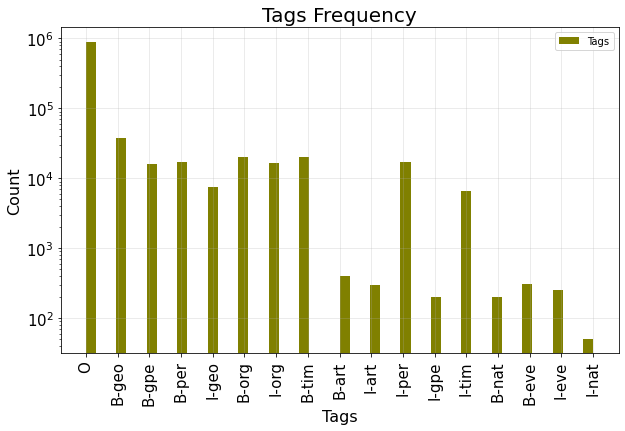

In [10]:
plt.figure(figsize = (10, 6))
plt.hist(dataframe.Tag, log = True, label = 'Tags', color = 'olive', bins = 50)
plt.xlabel('Tags', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title("Tags Frequency", fontsize = 20)
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [11]:
bar = dataframe['POS'].value_counts()
px.bar(x = bar.index,y = bar.values,title = "Total Count of Parts of Speech",color = bar.index)

## Data Preprocess

In [12]:
dataframe["Sentence #"] = dataframe["Sentence #"].fillna(method="ffill")
sentence = dataframe.groupby("Sentence #")["Word"].apply(list).values
pos = dataframe.groupby('Sentence #')['POS'].apply(list).values
tag = dataframe.groupby('Sentence #')['Tag'].apply(list).values

In [13]:
def process_data(data_path):
    df = pd.read_csv("/content/ner_dataset.csv", encoding="latin-1")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")

    enc_pos = preprocessing.LabelEncoder()
    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])
    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])

    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    pos = df.groupby("Sentence #")["POS"].apply(list).values
    tag = df.groupby("Sentence #")["Tag"].apply(list).values
    return sentences, pos, tag, enc_pos, enc_tag

sentence,pos,tag,enc_pos,enc_tag = process_data("/content/ner_dataset.csv")

In [14]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
MAX_LEN = 128
def tokenize(data,max_len = MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')
                        
        
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
X_train,X_test,y_train,y_test = train_test_split(sentence,tag,random_state=42,test_size=0.1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((43163,), (4796,), (43163,), (4796,))

In [16]:
input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)

100%|██████████| 43163/43163 [00:12<00:00, 3393.53it/s]


In [17]:
val_input_ids,val_attention_mask = tokenize(X_test,max_len = MAX_LEN)

100%|██████████| 4796/4796 [00:01<00:00, 3375.52it/s]


## Testing Padding and Truncation Length

In [18]:
# TEST: Checking Padding and Truncation length's
was = list()
for i in range(len(input_ids)):
    was.append(len(input_ids[i]))
set(was)

{128}

In [19]:
# Train Padding
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (128-len(y_test[i]))))
    
# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

{128}

In [20]:
# Train Padding
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (128-len(y_train[i]))))
    
# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

{128}

## Building BERT Model : Transfer Learning

In [21]:
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks,return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(17,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [22]:
with strategy.scope():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    model = create_model(bert_model,MAX_LEN)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

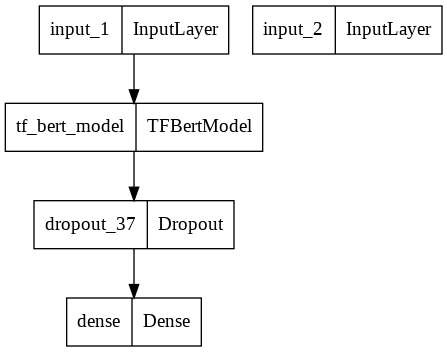

In [24]:
tf.keras.utils.plot_model(model)

## Traning Model

In [25]:
early_stopping = EarlyStopping(mode='min',patience=5)
history_bert = model.fit([input_ids,attention_mask],np.array(train_tag),validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),epochs = 25,batch_size = 30*2,callbacks = early_stopping,verbose = True)

Epoch 1/25


720/720 [==============================] - 220s 190ms/step - loss: 0.1589 - accuracy: 0.9565 - val_loss: 0.0711 - val_accuracy: 0.9774
Epoch 2/25
720/720 [==============================] - 71s 99ms/step - loss: 0.0626 - accuracy: 0.9798 - val_loss: 0.0439 - val_accuracy: 0.9861
Epoch 3/25
720/720 [==============================] - 72s 100ms/step - loss: 0.0449 - accuracy: 0.9853 - val_loss: 0.0354 - val_accuracy: 0.9890
Epoch 4/25
720/720 [==============================] - 72s 100ms/step - loss: 0.0367 - accuracy: 0.9880 - val_loss: 0.0312 - val_accuracy: 0.9903
Epoch 5/25
720/720 [==============================] - 72s 99ms/step - loss: 0.0318 - accuracy: 0.9896 - val_loss: 0.0286 - val_accuracy: 0.9911
Epoch 6/25
720/720 [==============================] - 72s 101ms/step - loss: 0.0282 - accuracy: 0.9908 - val_loss: 0.0265 - val_accuracy: 0.9919
Epoch 7/25
720/720 [==============================] - 72s 101ms/step - loss: 0.0256 - accuracy: 0.9917 - val_loss: 0.0246 - val_accuracy: 0.99

In [31]:
model.save_weights("/content/ner_bert_weights.h5")

In [36]:
model=model.load_weights("/content/ner_bert_weights.h5")

## Plotting

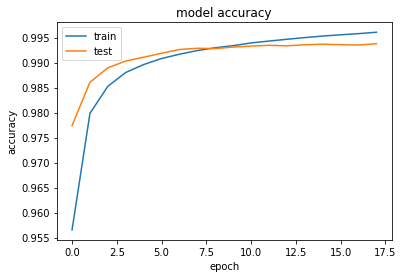

In [26]:
plt.plot(history_bert.history['accuracy'])
plt.plot(history_bert.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

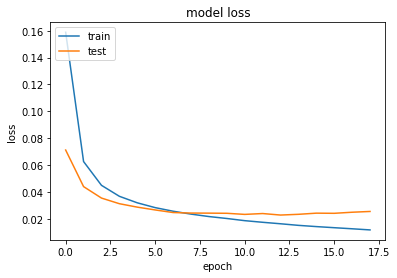

In [27]:
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testing Model

In [28]:
def pred(val_input_ids,val_attention_mask):
    return model.predict([val_input_ids,val_attention_mask])

In [29]:
def testing(val_input_ids,val_attention_mask,enc_tag,y_test):
    val_input = val_input_ids.reshape(1,128)
    val_attention = val_attention_mask.reshape(1,128)
    
    # Print Original Sentence
    sentence = tokenizer.decode(val_input_ids[val_input_ids > 0])
    print("Original Text : ",str(sentence))
    print("\n")
    true_enc_tag = enc_tag.inverse_transform(y_test)

    print("Original Tags : " ,str(true_enc_tag))
    print("\n")
    
    pred_with_pad = np.argmax(pred(val_input,val_attention),axis = -1) 
    pred_without_pad = pred_with_pad[pred_with_pad>0]
    pred_enc_tag = enc_tag.inverse_transform(pred_without_pad)
    print("Predicted Tags : ",pred_enc_tag)
    

In [30]:
testing(val_input_ids[0],val_attention_mask[0],enc_tag,y_test[0])

Original Text :  [CLS] the report calls on president bush and congress to urge chinese officials not to use the global war against terrorism as a pretext to suppress minorities'rights. [SEP]


Original Tags :  ['O' 'O' 'O' 'O' 'B-per' 'I-per' 'O' 'B-org' 'O' 'O' 'B-gpe' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']


Predicted Tags :  ['O' 'O' 'O' 'O' 'B-per' 'I-per' 'O' 'B-org' 'O' 'O' 'B-gpe' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']


Summary: The Original Tags and Predicted Tags matched well. This Means the model Performed very good.